In [1]:
%matplotlib inline

# Pytorch 自动编码器(auto-encoder)

In [2]:
# -*- coding: utf-8 -*-

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import xrange

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

torch.manual_seed(1)  # 网络参数初始化方案为1，可以保证模型效果重现

In [4]:
GPU_FLAG = torch.cuda.is_available()
print('CUDA available?', GPU_FLAG)

# hyper-parameter
training_epoch = 100
learning_rate = 1e-3
batch_size = 100

MNIST数据迭代器

In [5]:
import torch.utils.data as Data
import torchvision

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='data/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

train_loader = Data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

建立模型

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 5),  # compress to 3 features which can be visualized in plt
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(5, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(),  # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


autoencoder = AutoEncoder()
if GPU_FLAG:
    autoencoder.cuda()
else:
    pass
print(autoencoder)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

AutoEncoder (
  (encoder): Sequential (
    (0): Linear (784 -> 256)
    (1): ReLU ()
    (2): Dropout (p = 0.2)
    (3): Linear (256 -> 128)
    (4): ReLU ()
    (5): Dropout (p = 0.2)
    (6): Linear (128 -> 5)
    (7): ReLU ()
  )
  (decoder): Sequential (
    (0): Linear (5 -> 128)
    (1): ReLU ()
    (2): Dropout (p = 0.2)
    (3): Linear (128 -> 256)
    (4): ReLU ()
    (5): Dropout (p = 0.2)
    (6): Linear (256 -> 784)
    (7): Sigmoid ()
  )
)


原始图片展示

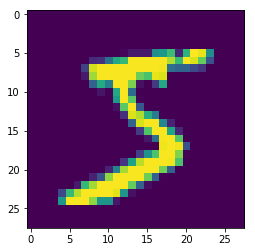

In [7]:
import numpy as np
import matplotlib.pylab as plt


# plot original
original_image = train_data[0][0].numpy()[0]
plt.imshow(original_image*255)

训练以及每一次展示

Episode 10 / 100, loss = 3.34139774181
Episode 20 / 100, loss = 3.11072496635
Episode 30 / 100, loss = 2.95660509852
Episode 40 / 100, loss = 2.90484190484
Episode 50 / 100, loss = 2.87384791269
Episode 60 / 100, loss = 2.85828112314
Episode 70 / 100, loss = 2.84362520371
Episode 80 / 100, loss = 2.8342296596
Episode 90 / 100, loss = 2.82688003158
Episode 100 / 100, loss = 2.81318902038


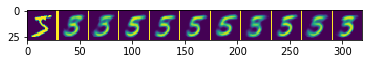

In [8]:
# visualization
img = original_image
blank = np.ones(shape=(28, 1))
img = np.concatenate((img, blank), axis=-1)

for epoch in xrange(1, 1 + training_epoch):
    cost = 0.0
    batch_episode=len(train_loader)//batch_size
    for _, (images, _) in enumerate(train_loader):
        if GPU_FLAG:
            batch_x = Variable(images.view(-1, 28 ** 2)).cuda()
        else:
            batch_x = Variable(images.view(-1, 28 ** 2))

        encoded, decoded = autoencoder(batch_x)

        loss = loss_func(decoded, batch_x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss.data[0]
    if epoch % 10 == 0:
        print('Episode %s / %s, loss = %s' % (epoch, training_epoch, float(cost) / len(train_data)))
        # plot model output
        if GPU_FLAG:
            image = Variable(torch.FloatTensor(original_image).view(1, -1)).cuda()
            _, decoded = autoencoder(image)
            image = decoded.view(28, 28).cpu().data.numpy()
        else:
            image = Variable(torch.FloatTensor(original_image).view(1, -1))
            _, decoded = autoencoder(image)
            image = decoded.view(28, 28).data.numpy()
        img = np.concatenate((img, blank, np.reshape(a=image, newshape=(28, 28))), axis=-1)
plt.imshow(img * 255)

In [9]:
from PIL import Image

Image.fromarray(img * 255).convert('L')